In [60]:
# Libraries I will use
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler



In [61]:
# Read Dataset
data = pd.read_csv("data/online_retail_II.csv")
retail_data = data.copy()

In [62]:
# First view to the dataset
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [63]:
retail_data.tail()
    

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France


In [64]:
retail_data.shape

(1067371, 8)

In [65]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [66]:
retail_data.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [67]:
retail_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
Customer ID,824364.0,15324.638504,1697.464450,12346.00,13975.00,15255.0,16797.00,18287.0


In [68]:
retail_data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [69]:
retail_data["Invoice"].nunique()

53628

In [70]:
retail_data["Quantity"].sum()

np.int64(10608492)

In [71]:
# Total revenue in the dataset
total_price_of_df = ((retail_data["Quantity"] * retail_data["Price"]).sum()).astype(int)

In [72]:
print(total_price_of_df)

19287250


In [73]:
retail_data["Description"].count()

np.int64(1062989)

In [74]:
# Dataset ordered from highest price to lowest price
retail_data.sort_values(by = "Price", ascending  = False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
748142,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom
241827,512771,M,Manual,1,2010-06-17 16:53:00,25111.09,NaN,United Kingdom
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,18910.69,NaN,United Kingdom
1050063,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,NaN,United Kingdom


In [75]:
# Dataset ordered from lowest price to highest price
retail_data.sort_values(by = "Price", ascending  = True).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Prepare the Dataset 

In this chapter, I'm going to prepare the dataset for RFM and cltv. I saw some wrong values while I review the dataset. I am going to clear them and I am going to change the type of the "InvoiceDate" column to DateTime type

In [76]:
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [77]:
retail_data["InvoiceDate"] = pd.to_datetime(retail_data["InvoiceDate"])

In [78]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [79]:
# Dropping the null values in the dataset.
retail_data.dropna(inplace = True)

The reason why we still have negative values in the Quantity section is invoices that start with C at the beginning because these invoices are return invoices. Show to you the values:

In [80]:
# Values starting with 'C'
retail_data[retail_data["Invoice"].str.contains("C", na = False)].head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


I have taken out the values starting with 'C'

In [81]:
retail_data=retail_data[~retail_data["Invoice"].str.contains("C",na=False)]

In [82]:
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [83]:
retail_data.shape

(805620, 8)

In [84]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805620 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805620 non-null  object        
 1   StockCode    805620 non-null  object        
 2   Description  805620 non-null  object        
 3   Quantity     805620 non-null  int64         
 4   InvoiceDate  805620 non-null  datetime64[ns]
 5   Price        805620 non-null  float64       
 6   Customer ID  805620 non-null  float64       
 7   Country      805620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 55.3+ MB


we will drop null values, took out the negative values and changed the type in this dataset

In [85]:
retail_data=retail_data[retail_data['Quantity']>0]
retail_data=retail_data[retail_data["Price"]>0]

In [86]:
#calculate the total_price and adding it 

retail_data["Total_prize"]=retail_data["Quantity"]*retail_data["Price"]

In [87]:
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_prize
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


Recency, frequency, monetary value (RFM) is a model used in marketing analysis that segments a company’s consumer base by their purchasing patterns or habits. In particular, it evaluates customers’ recency (how long ago they made a purchase), frequency (how often they make purchases), and monetary value (how much money they spend).

RFM is then used to identify a company’s or an organization’s best customers by measuring and analyzing spending habits to improve low-scoring customers and maintain high-scoring ones.

Understanding Recency, Frequency, Monetary Value

The RFM model is based on three quantitative factors:

Recency: How recently a customer has made a purchase

Frequency: How often a customer makes a purchase

Monetary value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The “best” customer would receive a top score in every category.

These three RFM factors can be used to reasonably predict how likely (or unlikely) it is that a customer will do business again with a firm or, in the case of a charitable organization, make another donation.

Prepare The Dataset for RFM

In [88]:
retail_data["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [89]:
# I specify this value to calculate recency values.
today_date = dt.datetime(2011,12,11)

In [90]:
df_rfm = retail_data.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (today_date - x.max()).days,
    "Invoice": lambda x: x.nunique(),
    "Total_prize": lambda x: x.sum()
})

In [91]:
df_rfm.head()

,InvoiceDate,Invoice,Total_prize
Customer ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40


In [92]:
df_rfm.columns=["Recency","Frequency","Monetary"]
df_rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40


In [93]:
df_rfm.sort_values(by="Monetary",ascending=False).head()

,Recency,Frequency,Monetary
Customer ID,,,
18102.0,1,145,608821.65
14646.0,2,151,528602.52
14156.0,10,156,313946.37
14911.0,2,398,295972.63
17450.0,9,51,246973.09


In [94]:
df_rfm.sort_values(by="Monetary",ascending=True).head()

,Recency,Frequency,Monetary
Customer ID,,,
14095.0,723,1,2.95
16738.0,298,1,3.75
13788.0,506,1,3.75
14792.0,64,1,6.20
15913.0,535,1,6.30


Recency_Score, Frequency_Score, Monetary_Score

I rate the recency, frequency, and monetary scores between 5 and 1. In this section, data with a score of 5 will be the data with the best recency score for us, data with a score of 1 will have the worst score.

Recency_Score: You know, high recency values are bad for us. Because high recency values represent the day the customer stays away from the company. Customers with low recency values are customers who do not stay away from the company.

Frequency_Score: High-frequency values are good for us. The Frequency value is that customer use how many use our company more.

Monetary_Score: High-monetary values are good for us. The Monetary value is the customer how much pays the company

In [95]:
# Create the recency_score, frequency_score, and monetary_score values.
df_rfm["Recency_Score"] = pd.qcut(df_rfm["Recency"], 5, labels = [5, 4, 3, 2, 1]) 
df_rfm["Frequency_Score"] = pd.qcut(df_rfm["Frequency"].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
df_rfm["Monetary_Score"] = pd.qcut(df_rfm["Monetary"], 5, labels = [1, 2, 3, 4, 5])

In [96]:
# Last version of df_rfm dataframe.
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
Customer ID,,,,,,
12346.0,326,12,77556.46,2,5,5
12347.0,3,8,5633.32,5,4,5
12348.0,76,5,2019.40,3,4,4
12349.0,19,4,4428.69,5,3,5
12350.0,311,1,334.40,2,1,2


In [97]:
# I create the RF_score using the recency_score and frequency_score.
df_rfm["RF_Score"] = df_rfm["Recency_Score"].astype(str) + df_rfm["Frequency_Score"].astype(str)

In [98]:
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score
Customer ID,,,,,,,
12346.0,326,12,77556.46,2,5,5,25
12347.0,3,8,5633.32,5,4,5,54
12348.0,76,5,2019.40,3,4,4,34
12349.0,19,4,4428.69,5,3,5,53
12350.0,311,1,334.40,2,1,2,21


In [99]:
# Seg_map is customer group.
seg_map = {
    r'[1-2][1-2]' : 'hibernatig',
    r'[1-2][3-4]' : 'at_Risk',
    r'[1-2]5' : 'cant-loose',
    r'3[1-2]' : 'about_to_sleep',
    r'33' : 'need_attention',
    r'[3-4][4-5]' : 'loyal_customers',
    r'41' : 'promising',
    r'51' : 'new_customers',
    r'[4-5][2-3]' : 'potential_loyalists',
    r'5[4-5]' : 'champions'}


In [100]:
# I create segment using RF_Score and segmap.
df_rfm["segment"] = df_rfm["RF_Score"].replace(seg_map, regex = True)

In [101]:
# Last version of df_rfm dataframe.
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12346.0,326,12,77556.46,2,5,5,25,cant-loose
12347.0,3,8,5633.32,5,4,5,54,champions
12348.0,76,5,2019.40,3,4,4,34,loyal_customers
12349.0,19,4,4428.69,5,3,5,53,potential_loyalists
12350.0,311,1,334.40,2,1,2,21,hibernatig


Review The RFM DataFrame 

In this chapter, I am going to review the df_rfm dataframe.

In the code block below, it sends us the mean, total and count of the segment values at recency, frequency and monetary values.

In [102]:
df_rfm[["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["mean", "sum", "count"])

Recency                Frequency               \
                           mean     sum count       mean    sum count   
segment                                                                 
about_to_sleep       107.618557   41756   388   1.360825    528   388   
at_Risk              373.942667  280457   750   3.904000   2928   750   
cant-loose           331.802817   23558    71  15.929577   1131    71   
champions              9.250000    7881   852  19.214789  16371   852   
hibernatig           460.012484  700139  1522   1.252300   1906  1522   
loyal_customers       68.306016   78347  1147   9.802964  11244  1147   
need_attention       114.241636   30731   269   3.156134    849   269   
new_customers         11.303571     633    56   1.000000     56    56   
potential_loyalists   26.297335   18750   713   2.589060   1846   713   
promising             39.281818    4321   110   1.000000    110   110   

                         Monetary                     
                             mean          sum count  
segment                                               
about_to_sleep         531.969905   206404.323   388  
at_Risk               1383.596253  1037697.190   750  
cant-loose            8355.677634   593253.112    71  
champions            10795.520581  9197783.535   852  
hibernatig             437.963135   666579.892  1522  
loyal_customers       4199.728592  4817088.695  1147  
need_attention        1283.114015   345157.670   269  
new_customers          356.257857    19950.440    56  
potential_loyalists   1155.427281   823819.651   713  
promising              324.497000    35694.670   110

Customer Lifetime Value (CLTV) is a prediction of the net profit attributed to the entire future relationship with a customer. It estimates the total value a business will derive from a customer relationship, taking into account the revenue, costs, and customer behavior patterns over a defined period of time. CLTV helps businesses understand the value of customer acquisition and retention, and guide decisions about investment in customer relationship management initiatives.

I am going to some changes to the dataset. Then I am going to create df_cltv and then apply the two models. They are BetaGeoFitter and GammaGammaFitter models. I am going to use the BetaGeoFilter model to predict how often shop of customer. I am going to use the GammaGammaFilter model to predict how much profit a customer will bring. And then I am going to analyze the data.

In [112]:
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_prize
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [115]:
# Values starting with 'C'
retail_data.sort_values(by="Quantity",ascending=True)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_prize
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,18.00
705119,552285,22754,SMALL RED BABUSHKA NOTEBOOK,1,2011-05-08 12:58:00,0.85,14684.0,United Kingdom,0.85
705118,552285,23256,CHILDRENS CUTLERY SPACEBOY,1,2011-05-08 12:58:00,4.15,14684.0,United Kingdom,4.15
705117,552285,21213,PACK OF 72 SKULL CAKE CASES,1,2011-05-08 12:58:00,0.55,14684.0,United Kingdom,0.55
705114,552285,21868,POTTING SHED TEA MUG,1,2011-05-08 12:58:00,1.25,14684.0,United Kingdom,1.25
...,...,...,...,...,...,...,...,...,...
127168,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,2010-03-17 13:09:00,0.10,13902.0,Denmark,1296.00
127166,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,2010-03-17 13:09:00,0.10,13902.0,Denmark,1296.00
90857,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152,2010-02-15 11:57:00,0.10,13902.0,Denmark,1915.20
587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60


Outlier calculationa and removing it

In [117]:
def outlier_removal(dataframe, column):
    quartile1=dataframe[column].quantile(0.01)
    quartile3=dataframe[column].quantile(0.99)
    IQR=quartile3-quartile1
    up_limit=quartile3+1.5*IQR
    low_limit=quartile1-1.5*IQR
    return up_limit,low_limit

def replace_with_threshold(dataframe,variable):
    up_limit, low_limit = outlier_removal(dataframe, variable)
    #dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit




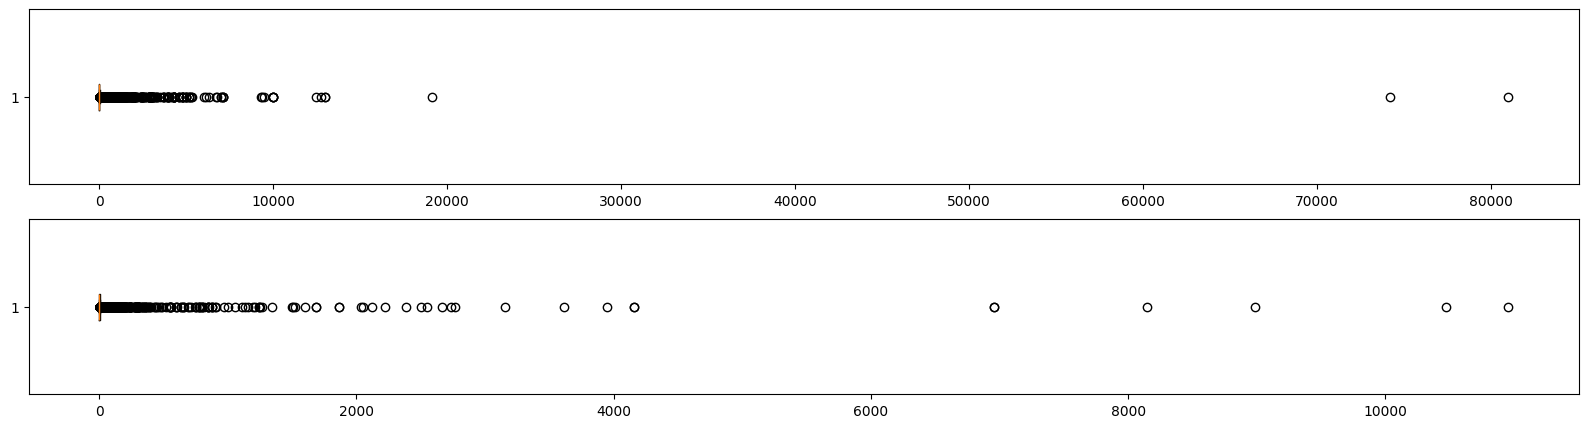

In [118]:
# I observe them before removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
col_list = ["Quantity", "Price"]
for i in range(0,2):
    ax[i].boxplot(retail_data[col_list[i]], vert = False)
plt.show()

In [121]:
# I apply the functions for remove the outlier.
replace_with_threshold(retail_data, "Quantity")
replace_with_threshold(retail_data, "Price")

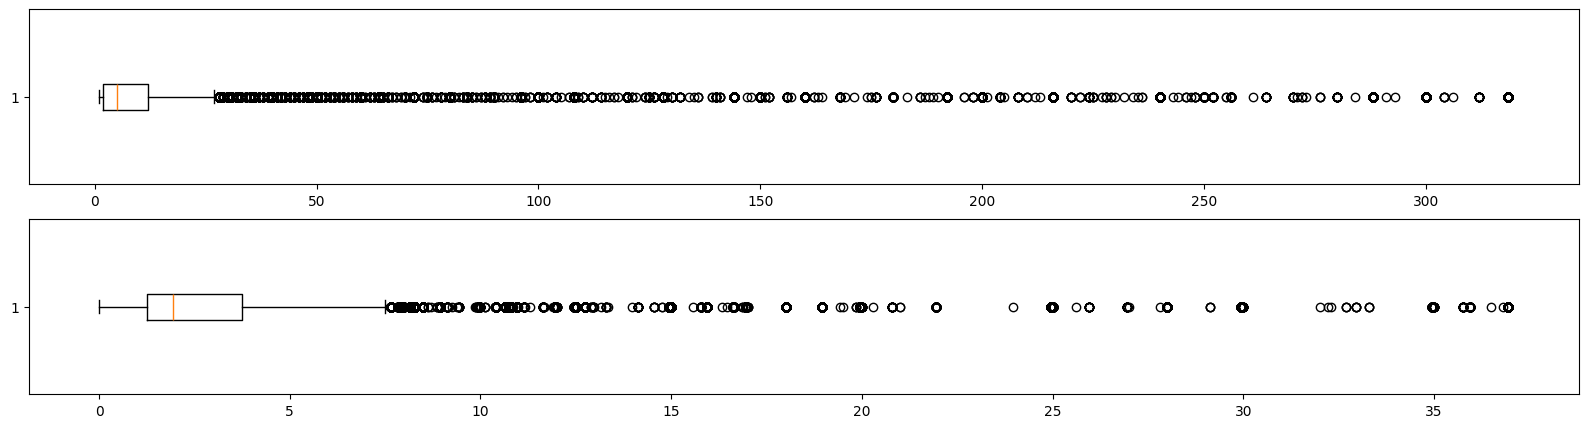

In [122]:
# I observe them after removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
for i in range(0,2):
    ax[i].boxplot(retail_data[col_list[i]], vert = False)
plt.show()

In [123]:
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_prize
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [124]:
retail_data["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [125]:
df_cltv= retail_data.groupby("Customer ID").agg({
    "InvoiceDate": [lambda x: (x.max() - x.min()).days,
                    lambda x: (today_date-x.min()).days],
    "Invoice": lambda x: x.nunique(),
    "Total_prize": lambda x: x.sum()
})

In [126]:
df_cltv.head()

InvoiceDate             Invoice Total_prize
             <lambda_0> <lambda_1> <lambda>    <lambda>
Customer ID                                            
12346.0             400        726       12    77556.46
12347.0             402        405        8     5633.32
12348.0             362        439        5     2019.40
12349.0             570        590        4     4428.69
12350.0               0        311        1      334.40

In [129]:
df_cltv.columns=df_cltv.columns.droplevel(0)

In [130]:
df_cltv.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0,400,726,12,77556.46
12347.0,402,405,8,5633.32
12348.0,362,439,5,2019.40
12349.0,570,590,4,4428.69
12350.0,0,311,1,334.40


In [131]:
df_cltv.columns=["recency","T","frequency","monetary"]

In [132]:
df_cltv.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,400,726,12,77556.46
12347.0,402,405,8,5633.32
12348.0,362,439,5,2019.40
12349.0,570,590,4,4428.69
12350.0,0,311,1,334.40
